# IMPORTS

In [15]:
import gdown
import zipfile
import os
from tqdm import tqdm
import shutil

from pydub import AudioSegment

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# === CONFIGURAZIONE ===
FILE_ID = "1zHPs5LurXfPwDDD2jXhpegEchvXTQWRP"  # <-- Cambia qui se serve
OUTPUT_ZIP = "train.zip"
EXTRACT_DIR = "train_data"

# Data manipulation

Now we are gonna download and manipulate the data to make them usable for the dataset that we are gonna create

In [2]:

# === 1. Scarica da Google Drive con barra di progresso ===
print("Inizio download del file da Google Drive...")

# Usa gdown per scaricare con URL
url = f"https://drive.google.com/uc?id={FILE_ID}"

# Usa una funzione di hook per mostrare la barra
def tqdm_hook(t):
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b
    return update_to

with tqdm(unit='B', unit_scale=True, desc=OUTPUT_ZIP, miniters=1) as t:
    gdown.download(url, OUTPUT_ZIP, quiet=True, use_cookies=False)

print("Download completato!")

# === 2. Estrazione del file ZIP ===
print(f"Estrazione di {OUTPUT_ZIP} nella cartella '{EXTRACT_DIR}'...")

# Crea cartella se non esiste
if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

with zipfile.ZipFile(OUTPUT_ZIP, 'r') as zip_ref:
    # tqdm per mostrare il progresso dei file estratti
    for file in tqdm(zip_ref.namelist(), desc="Estrazione file"):
        zip_ref.extract(file, EXTRACT_DIR)

print("Estrazione completata!")

os.remove(OUTPUT_ZIP)  # Rimuovi il file ZIP dopo l'estrazione


Inizio download del file da Google Drive...


train.zip: 0.00B [31:50, ?B/s]


Download completato!
Estrazione di train.zip nella cartella 'train_data'...


Estrazione file: 100%|██████████| 31994/31994 [01:05<00:00, 490.52it/s]


Estrazione completata!


In [23]:
shutil.rmtree("train_data\__MACOSX", ignore_errors=True)

<>:1: SyntaxWarning: invalid escape sequence '\_'
<>:1: SyntaxWarning: invalid escape sequence '\_'
C:\Users\radul\AppData\Local\Temp\ipykernel_10548\2668867813.py:1: SyntaxWarning: invalid escape sequence '\_'
  shutil.rmtree("train_data\__MACOSX", ignore_errors=True)  # Rimuovi la cartella metadata


Convert them from mp3 into wav

In [29]:
def convert_to_wav(file_path, output_dir):
    audio = AudioSegment.from_file(file_path)
    base = os.path.splitext(os.path.basename(file_path))[0]
    output_path = os.path.join(output_dir, base + ".wav")
    audio.export(output_path, format="wav")
    return output_path

if not os.path.exists("train_data_wav"):
    os.makedirs("train_data_wav")
clean_new_path = os.path.join("train_data_wav", "clean")
degraded_new_path = os.path.join("train_data_wav", "degraded")
if not os.path.exists(clean_new_path):
    os.makedirs(clean_new_path)
if not os.path.exists(degraded_new_path):
    os.makedirs(degraded_new_path)
# Converti tutti i file audio in formato WAV
for root, dirs, files in os.walk(EXTRACT_DIR):
    for file in files:
        if file.endswith(('.mp3', '.ogg', '.flac', '.m4a')):
            file_path = os.path.join(root, file)
            new_path = clean_new_path if "clean" in root else degraded_new_path
            convert_to_wav(file_path, new_path)
            
        

Now we'll create a Dataframe with the following structure:
audio_PATH, score, audio_PATH

Our "degradation_points.txt" has the points decided on the type of noise that has been applied on the original audio (0: small noise, 1.0: big noise).

Our goal is to create a model that assign a quality score to input audio (0: bad_quality, 1: very good quality). So to understand the idea behind the assigned score we have to consider 2 different cases:
- (clean, degraded): the final score will be 1.0 - score, cause if we had applied big noise the initial score will be almost 1, so the final quality score will be near 0.
- (degraded, clean): the final quality score will be equal to 1.0 cause clean represent the optimal quality that has to be reached

In [16]:
# Prepare a csv file containing all the necessary information
clean_dir = os.path.join('train_data_wav', 'clean')
degraded_dir = os.path.join('train_data_wav', 'degraded')
score_file = os.path.join(EXTRACT_DIR, 'degradation_points.txt')

# Load score file
df = pd.read_csv(score_file, sep='\t', header=None, names=['filename', 'score'])
# Add clean_path on csv
df['clean_path'] = df['filename'].apply(lambda x: os.path.join(clean_dir, x.split('/')[-1].split('_')[0] + '.wav'))
df['score'] = df['score'].astype(float)
df['degraded_path'] = df['filename'].apply(lambda x: os.path.join(degraded_dir, x.split('/')[-1].split(".")[0] + '.wav'))

df = df[["clean_path", "score", "degraded_path"]]

# Coppie (clean → degraded): il degraded è il target, qualità = 1 - score
forward = pd.DataFrame({
    # "source_path": df["clean_path"],
    "target_path": df["degraded_path"],
    "quality_score": 1.0 - df["score"]
})

# Coppie (degraded → clean): il clean è il target, qualità massima = 1.0
backward = pd.DataFrame({
    # "source_path": df["degraded_path"],
    "target_path": df["clean_path"],
    "quality_score": 1.0
})

# Combina
paired_df = pd.concat([forward, backward], ignore_index=True)

# Visualizza esempio
# print(paired_df.head())

# Salva se vuoi
paired_df.to_csv("train_data/paired_audio_quality_dataset.csv", index=False, header=False)



# Dataset build

In [17]:
class AudioPairQualityDataset(Dataset):
    def __init__(self, csv_path, transform=None, target_sample_rate=16000, duration=3.0):
        # self.data = pd.read_csv(csv_path, header=None, names=["source_path", "target_path", "quality_score"])
        self.data = pd.read_csv(csv_path, header=None, names=["target_path", "quality_score"])
        self.transform = transform
        self.sample_rate = target_sample_rate
        self.num_samples = int(self.sample_rate * duration)

    def __len__(self):
        return len(self.data)

    def _load_audio(self, path):
        waveform, sr = torchaudio.load(path)
        # Resample if needed
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)
        # Mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        # Pad/Trim to fixed length
        if waveform.shape[1] < self.num_samples:
            padding = self.num_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :self.num_samples]
        return waveform

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # source_audio = self._load_audio(row["source_path"])
        target_audio = self._load_audio(row["target_path"])
        score = torch.tensor(row["quality_score"], dtype=torch.float32)

        if self.transform:
            # source_audio = self.transform(source_audio)
            target_audio = self.transform(target_audio)

        return {
            # 'source_audio': source_audio,
            'target_audio': target_audio,
            'score': score
        }

In [27]:
csv_path = os.path.join(EXTRACT_DIR, 'paired_audio_quality_dataset.csv')

# Full dataset
mel_transform = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        hop_length=256,
        n_mels=96
    ),
    torchaudio.transforms.AmplitudeToDB()
)

full_dataset = AudioPairQualityDataset(csv_path, transform=mel_transform)

# Define lengths for the splits
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len  # Assicura somma esatta

# Random splits for train, test and validation
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)  # seed riproducibile
)

# DataLoader per ciascun set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
# get one dataloader element
print("Train loader example:")
for batch in train_loader:
    spectrogram = batch['target_audio']
    score = batch['score']
    print(f"Spectrogram shape: {spectrogram.shape}, Score shape: {score.shape}")
    break

Train loader example:
Spectrogram shape: torch.Size([32, 1, 96, 188]), Score shape: torch.Size([32])


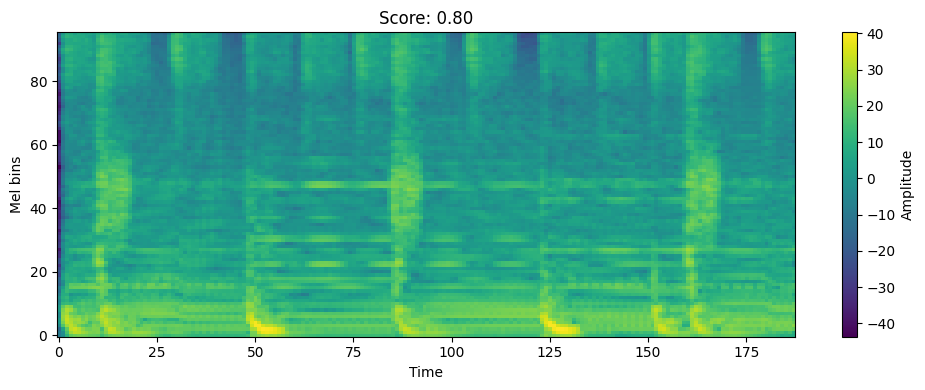

In [29]:


# Mostra il primo spettrogramma del batch
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram[0].squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title(f"Score: {score[0].item():.2f}")
plt.colorbar(label='Amplitude')
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.tight_layout()
plt.show()


# MODEL

In [30]:
class AudioQualityCNN(nn.Module):
    def __init__(self, n_mels=64):
        super(AudioQualityCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # [B, 32, 64, T]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),             # [B, 32, 32, T//2]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B, 64, 32, T//2]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),             # [B, 64, 16, T//4]

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [B, 128, 16, T//4]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))                  # [B, 128, 4, 4]
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),                     # [B, 128*4*4 = 2048]
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()                      # Output ∈ [0, 1]
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.regressor(x)
        return x.squeeze(1)  # Output shape: [B]

# TRAIN

In [31]:
def train(model, train_loader, val_loader, epochs=20, lr=1e-4, save_path="model/best_model.pth", use_amp=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.HuberLoss(delta=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    scaler = GradScaler(enabled=use_amp)

    best_val_loss = float('inf')
    patience = 3
    epochs_without_improvement = 0

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for epoch in range(epochs):
        model.train()
        total_loss, total_mae = 0.0, 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", colour="blue")

        for batch in loop:
            inputs = batch['target_audio'].to(device)
            targets = batch['score'].to(device)

            optimizer.zero_grad()

            with autocast(enabled=use_amp):
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * inputs.size(0)
            total_mae += torch.abs(outputs - targets).sum().item()

            loop.set_postfix(loss=loss.item(), mae=torch.abs(outputs - targets).mean().item())

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_mae = total_mae / len(train_loader.dataset)

        scheduler.step(avg_train_loss)
        tqdm.write(f"[Train] Loss: {avg_train_loss:.4f} | MAE: {avg_train_mae:.4f}")

        #### VALIDATION ####
        model.eval()
        val_loss, val_mae = 0.0, 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['target_audio'].to(device)
                targets = batch['score'].to(device)
                outputs = model(inputs)

                val_loss += loss_fn(outputs, targets).item() * inputs.size(0)
                val_mae += torch.abs(outputs - targets).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_mae = val_mae / len(val_loader.dataset)

        tqdm.write(f"[Val]   Loss: {avg_val_loss:.4f} | MAE: {avg_val_mae:.4f}")

        # Save model if improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            epochs_without_improvement = 0
            tqdm.write("\033[32m✓ Model saved\033[0m")
        else:
            epochs_without_improvement += 1
            tqdm.write(f"\033[31m✗ No improvement ({epochs_without_improvement}/{patience})\033[0m")

        if epochs_without_improvement >= patience:
            tqdm.write("\033[31m⏹ Early stopping triggered\033[0m")
            break

In [32]:
model = AudioQualityCNN()
train(model, train_loader, val_loader, epochs=20, lr=1e-4, save_path="model/best_model.pth", use_amp=True)

C:\Users\radul\AppData\Local\Temp\ipykernel_9368\2278151402.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
c:\Users\radul\anaconda3\envs\audio_restore_project\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/20:   0%|          | 0/350 [00:00<?, ?it/s]C:\Users\radul\AppData\Local\Temp\ipykernel_9368\2278151402.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
c:\Users\radul\anaconda3\envs\audio_restore_project\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/20: 100%|██████████| 350/350 [04:08<00:00,  1.41it/s, loss=0.0038, mae=0

[Train] Loss: 0.0141 | MAE: 0.1828
[Val]   Loss: 0.0119 | MAE: 0.1570
✓ Model saved


Epoch 2/20: 100%|██████████| 350/350 [04:00<00:00,  1.45it/s, loss=0.00562, mae=0.0865]


[Train] Loss: 0.0119 | MAE: 0.1548
[Val]   Loss: 0.0107 | MAE: 0.1415
✓ Model saved


Epoch 3/20: 100%|██████████| 350/350 [04:01<00:00,  1.45it/s, loss=0.0196, mae=0.225]  


[Train] Loss: 0.0112 | MAE: 0.1453
[Val]   Loss: 0.0115 | MAE: 0.1432
✗ No improvement (1/3)


Epoch 4/20: 100%|██████████| 350/350 [05:18<00:00,  1.10it/s, loss=0.0105, mae=0.14]    


[Train] Loss: 0.0108 | MAE: 0.1396
[Val]   Loss: 0.0101 | MAE: 0.1324
✓ Model saved


Epoch 5/20: 100%|██████████| 350/350 [05:59<00:00,  1.03s/it, loss=0.00499, mae=0.0726]


[Train] Loss: 0.0103 | MAE: 0.1334
[Val]   Loss: 0.0095 | MAE: 0.1232
✓ Model saved


Epoch 6/20: 100%|██████████| 350/350 [06:01<00:00,  1.03s/it, loss=0.0079, mae=0.102]  


[Train] Loss: 0.0100 | MAE: 0.1289
[Val]   Loss: 0.0095 | MAE: 0.1233
✗ No improvement (1/3)


Epoch 7/20: 100%|██████████| 350/350 [06:02<00:00,  1.04s/it, loss=0.0107, mae=0.136]  


[Train] Loss: 0.0098 | MAE: 0.1267
[Val]   Loss: 0.0091 | MAE: 0.1178
✓ Model saved


Epoch 8/20: 100%|██████████| 350/350 [05:51<00:00,  1.00s/it, loss=0.00871, mae=0.113] 


[Train] Loss: 0.0095 | MAE: 0.1226
[Val]   Loss: 0.0091 | MAE: 0.1209
✗ No improvement (1/3)


Epoch 9/20: 100%|██████████| 350/350 [04:20<00:00,  1.35it/s, loss=0.00535, mae=0.0756]


[Train] Loss: 0.0093 | MAE: 0.1200
[Val]   Loss: 0.0086 | MAE: 0.1116
✓ Model saved


Epoch 10/20: 100%|██████████| 350/350 [04:12<00:00,  1.39it/s, loss=0.015, mae=0.183]   


[Train] Loss: 0.0089 | MAE: 0.1153
[Val]   Loss: 0.0083 | MAE: 0.1083
✓ Model saved


Epoch 11/20: 100%|██████████| 350/350 [04:18<00:00,  1.36it/s, loss=0.00797, mae=0.111] 


[Train] Loss: 0.0086 | MAE: 0.1121
[Val]   Loss: 0.0085 | MAE: 0.1110
✗ No improvement (1/3)


Epoch 12/20: 100%|██████████| 350/350 [04:21<00:00,  1.34it/s, loss=0.00791, mae=0.105] 


[Train] Loss: 0.0081 | MAE: 0.1065
[Val]   Loss: 0.0077 | MAE: 0.0998
✓ Model saved


Epoch 13/20: 100%|██████████| 350/350 [04:14<00:00,  1.38it/s, loss=0.0172, mae=0.203]  


[Train] Loss: 0.0080 | MAE: 0.1046
[Val]   Loss: 0.0076 | MAE: 0.1014
✓ Model saved


Epoch 14/20: 100%|██████████| 350/350 [04:24<00:00,  1.33it/s, loss=0.0078, mae=0.104]   


[Train] Loss: 0.0077 | MAE: 0.1017
[Val]   Loss: 0.0076 | MAE: 0.0988
✗ No improvement (1/3)


Epoch 15/20: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s, loss=0.00918, mae=0.111]  


[Train] Loss: 0.0075 | MAE: 0.0999
[Val]   Loss: 0.0076 | MAE: 0.0983
✗ No improvement (2/3)


Epoch 16/20: 100%|██████████| 350/350 [04:20<00:00,  1.35it/s, loss=0.0045, mae=0.068]  


[Train] Loss: 0.0074 | MAE: 0.0979
[Val]   Loss: 0.0080 | MAE: 0.1030
✗ No improvement (3/3)
⏹ Early stopping triggered


# Test the trained model

In [34]:
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    loss_fn = nn.MSELoss()
    total_loss = 0.0
    total_mae = 0.0
    correct_absolute = 0
    correct_relative = 0
    total_samples = 0

    absolute_threshold = 0.1
    relative_threshold = 0.1  # 10% del target

    with torch.no_grad():
        loop = tqdm(test_loader, total=len(test_loader), desc="Testing", colour="green")
        for batch in loop:
            inputs = batch['target_audio'].to(device)
            targets = batch['score'].to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            errors = torch.abs(outputs - targets)

            total_loss += loss.item() * inputs.size(0)
            total_mae += errors.sum().item()

            correct_absolute += (errors < absolute_threshold).sum().item()
            correct_relative += (errors < (relative_threshold * targets)).sum().item()

            total_samples += inputs.size(0)

            loop.set_postfix(loss=loss.item(), mae=errors.mean().item())

    avg_test_loss = total_loss / total_samples
    avg_test_mae = total_mae / total_samples
    accuracy_absolute = correct_absolute / total_samples * 100
    accuracy_relative = correct_relative / total_samples * 100

    print(f"\033[32mTest Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.2f}, "
          f"Accuracy (<{absolute_threshold}): {accuracy_absolute:.2f}%, "
          f"Relative Accuracy (<{int(relative_threshold * 100)}%): {accuracy_relative:.2f}%\033[0m")

In [35]:
model = AudioQualityCNN()
model.load_state_dict(torch.load("model/best_model.pth"))
test(model, test_loader)

Testing: 100%|██████████| 75/75 [00:47<00:00,  1.57it/s, loss=0.0704, mae=0.163]  

Test Loss: 0.0420, Test MAE: 0.10, Accuracy (<0.1): 73.42%, Relative Accuracy (<10%): 70.42%
